In [1]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd

import scvi
from scvi.external import RNAStereoscope, SpatialStereoscope

import sys

import os

In [3]:
np.random.seed(42)
# def get_freer_gpu():
#     os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
#     memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
#     max_idx = np.where(memory_available == np.max(memory_available))[0]
#     return np.random.permutation(max_idx)[0]
# os.environ['CUDA_VISIBLE_DEVICES'] = str(get_freer_gpu())
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
scrna_path = "/home/comp/cszrwang/data/MOB/mob_sc_celltype.h5ad"
spatial_path = "/home/comp/cszrwang/data/MOB/mob_st.h5ad"
celltype_key = 'celltype'
output_path = "/home/comp/cszrwang/results/Deconvolution/results/MOB/Stereoscope/"
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [8]:
sc_adata = sc.read_h5ad(scrna_path)
st_adata = sc.read_h5ad(spatial_path)

sc.pp.filter_genes(sc_adata, min_counts = 10)

non_mito_genes_list = [name for name in sc_adata.var_names if not name.startswith('MT-')]
sc_adata = sc_adata[:, non_mito_genes_list]

sc_adata.layers["counts"] = sc_adata.X.astype(int).copy()
sc.pp.normalize_total(sc_adata, target_sum = 1e5)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

In [10]:
sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes = 7000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)

intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

In [11]:
RNAStereoscope.setup_anndata(sc_adata, layer = "counts", labels_key = celltype_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 100/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.80s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=2.32e+5]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=2.32e+5]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Epoch 10000/10000: 100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:12<00:00, 72.60it/s, v_num=1, train_loss_step=1.59e+6, train_loss_epoch=1.61e+6]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 10000/10000: 100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:12<00:00, 31.95it/s, v_num=1, train_loss_step=1.59e+6, train_loss_epoch=1.61e+6]


<Axes: xlabel='epoch'>

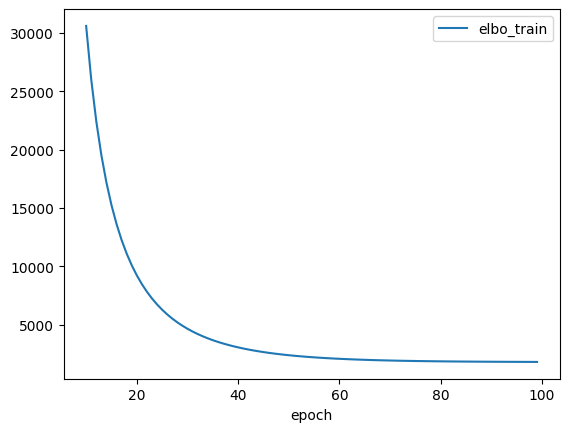

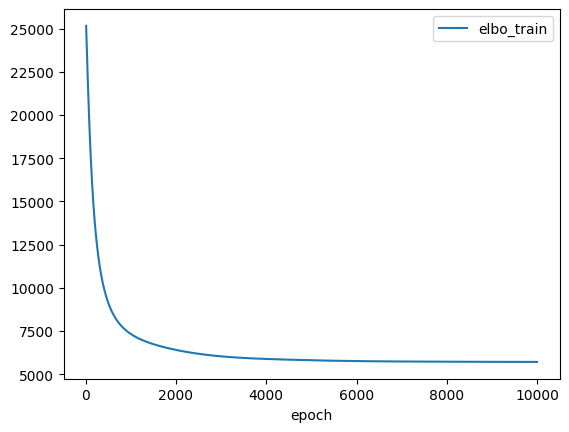

In [12]:
stereo_sc_model = RNAStereoscope(sc_adata)
stereo_sc_model.train(max_epochs = 100)
stereo_sc_model.history["elbo_train"][10:].plot()

st_adata.layers["counts"] = st_adata.X.copy()
SpatialStereoscope.setup_anndata(st_adata, layer="counts")

spatial_model = SpatialStereoscope.from_rna_model(st_adata, stereo_sc_model)
spatial_model.train(max_epochs = 10000)
spatial_model.history["elbo_train"][10:].plot()

In [13]:
spatial_model.get_proportions().to_csv(output_path + '/Stereoscope_result.csv')